#### Metrics
- % alts w/ uncorrected samp. prob > pop. mean prob: should decrease as $N_s$ --> $N_p$
- avg. (max corrected samp. prob - true max prob): should approach zero as $N_s$ --> $N_p$

#### Notes
- bias of naive correction factor estimator seems very related to "spikey-ness" of distribution. but mean abs err does not!
- probability distribution seems to get less spikey with more parameters
- Spikey-ness is a function of model error!

In [1]:
import numpy as onp
import pandas as pd
from itertools import product
from tqdm import tqdm
import jax
import jaxlib
from jax import grad, jit, vmap, remat
import jax.numpy as np
import jax.random as random
from jax.experimental import optimizers
from jax.ops import index, index_update
import seaborn as sns
from matplotlib import pyplot as plt
import time
from functools import partial

In [2]:
import matplotlib as mpl
import statsmodels.api as sm

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
def softmax(u, scale=1, corr_factor=1):
    """ 
    Probability equation for multinomial logit. 
    
    Parameters:
    ------------
    u: array-like. Array containing the utility estimate for each alternative. 
    scale: (int, optional ) - Scaling factor for exp(scale * u). Default = 1 
    axis: (None or int or tuple of ints, optional) – Axis or axes over which the sum is taken. By default axis is None, and all elements are summed.

    Returns: 
    ----------
    (array) Probabilites for each alternative
    """
    exp_utility = np.exp(scale * u)
    sum_exp_utility = np.sum(exp_utility * corr_factor, keepdims=True)
    proba = exp_utility / sum_exp_utility
    return proba

def logsums(u, scale=1, axis=1, corr_factor=1):
    """ 
    Maximum expected utility 
    Parameters:
    ------------
    u: array-like. Array containing the unscaled utility estimate for each alternative. 
    scale: (int, optional ) - Scaling factor for exp(scale * u). Default = 1 
    axis: (None or int or tuple of ints, optional) – Axis or axes over which the sum is taken. By default axis is None, and all elements are summed.

    return: 
    -------
    Maximum expected utility of the nest
    """
    return (1 / scale) * np.log(np.sum(np.exp(scale * u) * corr_factor, axis=axis))

class large_mnl():
    """
    Differentiable approach for multinomial logit with large alternative set 
    """

    def __init__(self, model_object=None, coeffs=None, n_choosers=None, n_alts=None):
        self.weights = coeffs
        self.n_choosers = n_choosers
        self.n_alts = n_alts
        # self.constrains  = constrains 
        ## TO DO: yaml file
            
    def utilities(self, x):
        """ Calculates the utility fuction of weights w and data x 
        Parameters:
        ------------
        x = Jax 2d array, OrcaTable wrapper name, Pandas DataFrame. Column names must match coefficient names.
            if a Jax array, order of columns should be the same order as the coeffient names. 

        Return:
        ------------
        2-d jax numpy array with utilities for eahc alternative.
        """

        w = self.weights
        n = self.n_choosers
        j = self.n_alts
        return np.dot(x, w.T).reshape(n,j)

    def probabilities(self, x, scale=1, corr_factor=1):
        ''' Estimates the probabilities for each alternative in the choice set for each individual '''
        utils = self.utilities(x)
        return vmap(softmax, in_axes=(0, None, None))(utils, scale, corr_factor)

    def logsum(self, x):
        ''' Estimates the maximum expected utility for all alternatives in the choice set
            Scale parameter normalized to 1. 
        '''
        utils = self.utilities(x)
        return vmap(logsums)(utils)

    def simulation(self, x, key):
        ''' 
        Monte Carlo simulation. 
        
        Parameters
        ----------
        x: 2-d Jax numpy array
        key: jax PRNG Key object
        
        Return
        -------
        - numpy.array 

        '''
        utils = self.utilities(x)
        shape = utils.shape
        keys = random.split(key, shape[0])

        @jit
        def single_simulation(u, key):
            return random.categorical(key, u)

        choices = vmap(single_simulation, in_axes=(0, 0))(utils, keys)
        return choices  ### Assuming alternative name starts at 0

In [5]:
def get_mct(choosers, alts, var_mats=None, chooser_alts=None):
    
    num_choosers = choosers.shape[0]
    num_alts = alts.shape[0]
    sample_size = chooser_alts.shape[1]
    
    if chooser_alts is None:
        mct = np.tile(alts, (num_choosers, 1))
        mct = np.hstack((mct, choosers.repeat(num_alts)))
    else:
        mct = np.vstack([alts[chooser_alts[i, :], :] for i in range(num_choosers)])
        mct = np.hstack((mct, choosers.repeat(sample_size).reshape(-1, 1)))
    
    return mct

def create_data(num_alts, pop_to_alts_ratio, num_vars=5):
    
    # create choosers
    n_choosers = int(pop_to_alts_ratio * num_alts)
    choosers = onp.random.lognormal(0, 0.5, n_choosers)  # 1 chooser attribute
    
    # initialize alts
    alts = onp.zeros((num_alts, num_vars))
    
    # dist to CBD
    alts[:, 0] = onp.random.lognormal(0, 1, num_alts)  # Dist to CBD
    
    # size terms
    for i in range(1, num_vars - 1):
        split_val = int(onp.floor(num_alts * .5))
        alts[:split_val, i] = onp.random.normal(1, 1, split_val)  # first 1/2 of alts have mean = 1
        alts[split_val:, i] = onp.random.normal(0.5, 1, num_alts - split_val)  # rest of alts have mean 0.5
    
    # interaction term
    alts[:, -1] = onp.random.lognormal(1, .5, num_alts)
    
    return np.array(choosers), np.array(alts)
    

In [29]:
random.permutation(key, np.array([1,2,3]))

DeviceArray([2, 3, 1], dtype=int32)

In [18]:
b = np.array([1,2,3])

In [27]:
b.at[1].set(-999)

DeviceArray([   1, -999,    3], dtype=int32)

In [30]:
@partial(jit, static_argnums=[3])
def interaction(chooser_val, key, alts, sample_size):

    total_alts = alts.shape[0]
    sample_rate = sample_size / total_alts
    
    alts_idxs = np.array(range(total_alts))
    shuffled_idxs = random.permutation(key, alts_idxs)
    if sample_size < total_alts:
        alts_idxs = alts_idxs[shuffled_idxs[:sample_size]]


    alts = alts[alts_idxs, :]
    
    idx_alt_intx = -1
    coeffs = np.array([-1, 1, 1, 1, 1])
    interacted = alts[:, idx_alt_intx] / chooser_val
    alts2 = alts.at[:, idx_alt_intx].set(interacted)
    
    logits = np.dot(alts2, coeffs.T)
    probas = softmax(logits)
    probas = probas.flatten()
    
    pop_mean_prob = 1 / num_alts
    pct_probs_gt_pop_mean = np.sum(probas > pop_mean_prob) / sample_size
    
    max_prob = np.nanmax(probas)
    
    pctl_95 = np.quantile(probas, .95)
    corr_probas = probas / (1 / sample_rate)
    
    return max_prob, pct_probs_gt_pop_mean

In [31]:
def get_probs(choosers, alts, key, sample_size):
    """VMAP the interaction function over all choosers' values"""
    num_choosers = choosers.shape[0]
    keys = random.split(key, num_choosers)
    probas_all = vmap(interaction, in_axes=(0, 0, None, None))(choosers, keys, alts, sample_size)
    return probas_all

In [32]:
pop_to_alts_ratio = 750 / 200

In [33]:
alts_sizes = [200, 2000, 2e4, 2e5, 2e6]
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
coeffs = np.array([-1, 1, 1, 1, 1])

In [34]:
n_alts_dict = {}
metrics = pd.DataFrame(
    columns=[
        'num_alts', 'sample_rate', 'med_pct_probs_gt_pop_mean',
        'med_max_corr_prob', 'pct_choosers_1_gt_95'])

key = random.PRNGKey(0)
for num_alts in alts_sizes:
    
    num_alts = int(num_alts)
    pop_mean_prob = 1 / num_alts
    
    choosers, alts = create_data(num_alts, pop_to_alts_ratio)
    num_choosers = choosers.shape[0]
    print(num_alts, " ALTS, ", num_choosers, " CHOOSERS")
    now = time.time()
    probs_true_max, pct_true_probs_gt_pop_mean = get_probs(choosers, alts, key, num_alts)
    later = time.time()
    print("Took {0} s to compute true probs.".format(np.round(later - now)))

    now = time.time()
    med_pct_probs_gt_pop_mean = np.median(pct_true_probs_gt_pop_mean)
    med_max_prob = np.median(probs_true_max)
    later = time.time()
    print("Took {0} s to compute true prob. metrics".format(np.round(later - now)))
    
    metrics = pd.concat((metrics, pd.DataFrame([{
        'num_alts': num_alts,
        'sample_rate': 1,
        'med_pct_probs_gt_pop_mean': med_pct_probs_gt_pop_mean,
        'med_max_corr_prob': med_max_prob}])))

    for sample_rate in sample_rates:
        now = time.time()
        
        sample_size = int(num_alts * sample_rate)
        
        probs_samp_max, pct_samp_probs_gt_pop_mean = get_probs(choosers, alts, key, sample_size)
        later = time.time()
        print("Took {0} s to compute {1}% sample probs.".format(np.round(later - now), sample_rate * 100))
        
        # metrics
        now = time.time()
        med_pct_probs_gt_pop_mean = np.median(pct_samp_probs_gt_pop_mean)
        med_max_corr_prob = np.median(probs_samp_max) * sample_rate
        later = time.time()
        print("Took {0} s to compute {1}% sample metrics.".format(np.round(later - now), sample_rate * 100))

        metrics = pd.concat((metrics, pd.DataFrame([{
            'num_alts': num_alts,
            'sample_rate': sample_rate,
            'med_pct_probs_gt_pop_mean': med_pct_probs_gt_pop_mean,
            'med_max_corr_prob': med_max_corr_prob}])))
    

200  ALTS,  750  CHOOSERS
Took 0.0 s to compute true probs.
Took 0.0 s to compute true prob. metrics
Took 0.0 s to compute 10.0% sample probs.
Took 0.0 s to compute 10.0% sample metrics.
Took 0.0 s to compute 20.0% sample probs.
Took 0.0 s to compute 20.0% sample metrics.
Took 0.0 s to compute 30.0% sample probs.
Took 0.0 s to compute 30.0% sample metrics.
Took 0.0 s to compute 40.0% sample probs.
Took 0.0 s to compute 40.0% sample metrics.
Took 0.0 s to compute 50.0% sample probs.
Took 0.0 s to compute 50.0% sample metrics.
Took 0.0 s to compute 60.0% sample probs.
Took 0.0 s to compute 60.0% sample metrics.
Took 0.0 s to compute 70.0% sample probs.
Took 0.0 s to compute 70.0% sample metrics.
Took 0.0 s to compute 80.0% sample probs.
Took 0.0 s to compute 80.0% sample metrics.
Took 0.0 s to compute 90.0% sample probs.
Took 0.0 s to compute 90.0% sample metrics.
2000  ALTS,  7500  CHOOSERS
Took 0.0 s to compute true probs.
Took 1.0 s to compute true prob. metrics
Took 0.0 s to compute 

2021-11-02 09:51:18.813544: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 22.35GiB (rounded to 24000001024)requested by op 
2021-11-02 09:51:18.813972: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:467] *___________________________________________________________________________________________________
2021-11-02 09:51:18.814054: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:1955] Execution of replica 0 failed: Resource exhausted: Out of memory while trying to allocate 24000000792 bytes.


RuntimeError: Resource exhausted: Out of memory while trying to allocate 24000000792 bytes.

In [40]:
metrics = metrics.astype(float)

Text(0.5, 0, 'Sample Rate')

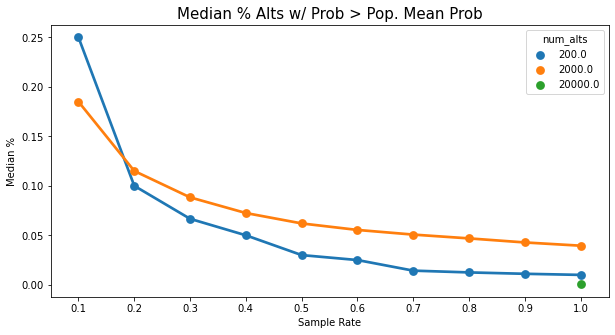

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=metrics, x='sample_rate', y ='med_pct_probs_gt_pop_mean', hue='num_alts', ax=ax)
ax.set_title("Median % Alts w/ Prob > Pop. Mean Prob", fontsize=15)
ax.set_ylabel("Median %")
ax.set_xlabel("Sample Rate")

Text(0.5, 0, 'Sample Rate')

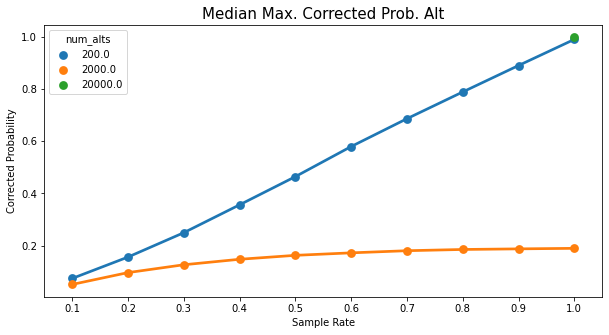

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=metrics, x='sample_rate', y ='med_max_corr_prob', hue='num_alts', ax=ax)
ax.set_title("Median Max. Corrected Prob. Alt", fontsize=15)
ax.set_ylabel("Corrected Probability")
ax.set_xlabel("Sample Rate")

In [48]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         samp_corr_maxs = sample_size_data['probs_samp_corr'].max(axis=1)
#         g = sns.kdeplot(samp_corr_maxs, fill=True,ax=axarr[i], label=str(sample_size))
#         polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#         color = polys[-1].get_facecolor()
#         axarr[i].vlines(onp.nanmedian(samp_corr_maxs), 0, 20, lw=1, color=color, alpha=1, linestyle='--')
#     probs_true_max = n_alts_data[1]['probs_true'].max(axis=1)
#     g = sns.kdeplot(probs_true_max, fill=True, ax=axarr[i], label=str(1), lw=3)
#     polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#     color = polys[-1].get_facecolor()
#     axarr[i].vlines(onp.nanmedian(probs_true_max), 0, 20, lw=2, color=color, alpha=1)
#     axarr[i].legend(title='Sample Rate')
#     axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)
# fig.suptitle("Max. Corrected Probability Across Choosers", fontsize=20)

In [47]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         samp_maxs = sample_size_data['probs_true_samp'].max(axis=1)
#         g = sns.kdeplot(samp_maxs, fill=True, ax=axarr[i], label=str(sample_size))
#         polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#         color = polys[-1].get_facecolor()
#         axarr[i].vlines(onp.nanmedian(samp_maxs), 0, 10, lw=1, color=color, alpha=1, linestyle='--')
#     probs_true_max = n_alts_data[1]['probs_true'].max(axis=1)
#     g = sns.kdeplot(probs_true_max, fill=True, ax=axarr[i], label=str(1), lw=3, )
#     polys = [poly for poly in g.get_children() if type(poly) == mpl.collections.PolyCollection]
#     color = polys[-1].get_facecolor()
#     axarr[i].vlines(onp.nanmedian(probs_true_max), 0, 10, lw=2, color=color,alpha=1, )
#     axarr[i].legend(title='Sample Rate')
#     axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)
# fig.suptitle("Max. True Probability Across Choosers", fontsize=20)

In [46]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
    
#     probs_true = n_alts_data[1]['probs_true']
#     true_massing = np.nansum(probs_true, axis=0)
#     order = true_massing.argsort()[::-1]
#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
            
#         probs_samp_sparse = sample_size_data['probs_samp_sparse']
#         sampled_massing = np.nansum(probs_samp_sparse, axis=0)
#         massing_err = (true_massing - sampled_massing)
#         z = sm.nonparametric.lowess(massing_err[order], true_massing[order], frac=1/20, it=6)
#         axarr[i].plot(z[:,0], z[:,1], lw=1, alpha=0.4)
#         axarr[i].scatter(true_massing[order], massing_err[order], marker='o', label=str(sample_size), alpha=0.5)

#     axarr[i].axhline(y=0, color='k', linestyle='--', lw=0.5)

#     axarr[i].legend(title='Sample Rate')
#     axarr[i].set_ylabel('Error')
#     axarr[i].set_xscale('log')
#     axarr[i].set_yscale('symlog')
#     axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)

# axarr[i].set_xlabel('True Probability Mass')

# fig.suptitle("Probability Massing Error", fontsize=20)
# fig.tight_layout()

In [45]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
    
#     probs_true = n_alts_data[1]['probs_true']
#     true_massing = np.nansum(probs_true, axis=0) / probs_true.shape[0]
#     order = true_massing.argsort()[::-1]

#     axarr[i].plot(range(num_alts), true_massing[order], color='b', alpha=.5, label='True')

#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         probs_samp_sparse = sample_size_data['probs_samp_sparse']
#         samp_massing = np.nansum(probs_samp_sparse, axis=0) / probs_true.shape[0]
#         axarr[i].plot(range(num_alts), samp_massing[order], label=sample_size, lw=0.5)

#         axarr[i].legend(title='Sample Rate')
#         axarr[i].set_title('', fontsize=15)
#         axarr[i].set_ylabel('% Probability Mass')
#         axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)

# axarr[i].set_xlabel('Alternative ID')

# fig.suptitle("Probability Massing of Alts - Sorted by True Prob. Mass", fontsize=20)
# fig.tight_layout()

In [44]:
# fig, axarr = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
# for i, (num_alts, n_alts_data) in enumerate(n_alts_dict.items()):
    
#     probs_true = n_alts_data[1]['probs_true']
#     true_massing = np.nansum(probs_true, axis=0) / probs_true.shape[0]
#     order = true_massing.argsort()[::-1]

#     axarr[i].plot(range(num_alts), true_massing[order], color='b', alpha=.5, label='True')

#     for sample_size, sample_size_data in n_alts_data.items():
#         if sample_size == 1:
#             continue
#         probs_samp_sparse = sample_size_data['probs_samp_sparse']
#         samp_massing = np.nansum(probs_samp_sparse, axis=0) / probs_true.shape[0]
#         axarr[i].plot(range(num_alts), samp_massing[order], label=sample_size, lw=0.5)

#         axarr[i].legend(title='Sample Rate')
#         axarr[i].set_title('', fontsize=15)
#         axarr[i].set_ylabel('% Probability Mass')
#         axarr[i].set_xlim(-1, 50)
#         axarr[i].set_title("$N$ = {0}".format(num_alts), fontsize=15)

# axarr[i].set_xlabel('Alternative ID')

# fig.suptitle("Probability Massing of Top 50 Alts - Sorted by True Prob. Mass", fontsize=20)
# fig.tight_layout()